In [1]:
import gc
import glob
import pandas
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

In [2]:
def removeFiles(files, log=False):
    ''' Функция удаления файлов '''
    chunks = len(files)
    percent = -1
    for file in files:
        if (log) and (round(i * 100 / chunks) != percent):
            percent = round(i * 100 / chunks)
            print('\r', f'{percent}% chunk: {i+1}/{chunks+1}', end='   ')
        os.remove(file)
    print('\r', f'100% chunk: {chunks+1}/{chunks+1}')
# --------------------------------
def save(df_chunk, path, index=True):
    df_chunk.to_csv(f'{path}.csv', index=index)

In [3]:
def scoreTime(name):
    '''Декоратор для вывода времени работы функции (начало-конец)'''
    def wrapper(func):
        def function(*args, **kwargs):
            print('\r', name, ': start\t', datetime.now())
            res = func(*args, **kwargs)
            print('\r', name, ': end  \t', datetime.now())
            return res
        return function
    return wrapper

In [4]:
# ==================================================================
# ----- Конфигурация сессии для экспериментов-----------------------
# ==================================================================
LOCAL = False  # Тип метрики. True - локально, False - Kaggle
SAVE  = True # Сохранять ли файлы. Нужно при сохранении датасета
SHOW  = True # Выводить ли таблицы в процессе
GPU   = True # Использовать GPU
# -----------------------------------------------------------------
params = {
    'epoch': 20,
    'lr': 0.1
}

In [5]:
if GPU:
    import cudf
pd = cudf if GPU else pandas
print('We will use RAPIDS version',cudf.__version__) if GPU else print('We will use CPU...')

We will use RAPIDS version 21.10.01


In [6]:
# ----- Prepare data -----

In [7]:
%%time
# ~ 35s
path = 'otto-full-optimized-memory-footprint' # 'otto-train-and-test-data-for-local-validation' if LOCAL else 
train = pd.read_parquet(f'../input/{path}/train.parquet')
test = pd.read_parquet(f'../input/{path}/test.parquet')

# обхединяем данные о товарах из тренировки и теста для обучения
train_pairs = pd.concat([train, test])[['session', 'aid']]
del train, test

# составляем пары товаров X->Y
train_pairs['aid_next'] = train_pairs.groupby('session').aid.shift(-1)
train_pairs = train_pairs[['aid', 'aid_next']].dropna().reset_index(drop=True)

# сохраняем на диск для Merlin Dataloader
train_pairs.to_pandas().to_parquet('train_pairs.parquet')
train_pairs[-10_000_000:].to_pandas().to_parquet('valid_pairs.parquet')

# Выясняем количество уникальных товаров
cardinality_aids = max(train_pairs['aid'].max(), train_pairs['aid_next'].max())
print('Cardinality of items is',cardinality_aids)

del train_pairs; gc.collect()

Cardinality of items is 1855602
CPU times: user 10.9 s, sys: 3.87 s, total: 14.8 s
Wall time: 37.8 s


30

In [8]:
def plotData(uid, data, count=-1, step=25, history=False):
    ''' Отображаем эмбединг'''
    tmp = data.loc[data.session==uid].reset_index(drop=True)['aid'].values

    plt.figure(figsize=params.get('figsize') or (10,10))
    plt.scatter(em_2d[:count:step,0],em_2d[:count:step,1],s=1,label='All 1.8M items!')

    if history:
        old_xy = []; pos = []
        for i,(x,y) in enumerate(zip(em_2d[tmp][:,0],em_2d[tmp][:,1])):
            new_location = True
            for j in old_xy:
                if (np.abs(x-j[0])<5) & (np.abs(y-j[1])<5):
                    new_location = False
            if new_location:
                plt.text(x,y,f'{i+1}',size=18)
                old_xy.append( (x,y) )
                pos.append(i)

    plt.show()

In [9]:
# ----- Class MatrixFactorization -----

In [10]:
import torch
from torch import nn

class MatrixFactorization(nn.Module):
    def __init__(self, n_aids, n_factors):
        '''
        -- n_aids    - развер словаря элементов
        -- n_factors - размер вектора ембединга
        '''
        super().__init__()
        self.aid_factors = nn.Embedding(n_aids, n_factors, sparse=True)
        
    def forward(self, aid1, aid2):
        aid1 = self.aid_factors(aid1)
        aid2 = self.aid_factors(aid2)
        
        return (aid1 * aid2).sum(dim=1)
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [11]:
!pip install merlin-dataloader==0.0.2
from merlin.loader.torch import Loader
from merlin.io import Dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 33.8 kB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 798.4 kB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Installing build dependencies ... - \ 

In [12]:
# ----- Вычисление матрицы факторизации -----

In [13]:
train_ds = Dataset('train_pairs.parquet')
train_dl_merlin = Loader(train_ds, 65536, True)
valid_ds = Dataset('valid_pairs.parquet')
valid_dl_merlin = Loader(valid_ds, 65536, True)

In [14]:
from torch.optim import SparseAdam

num_epochs = params['epoch']
lr = params['lr']

model = MatrixFactorization(cardinality_aids+1, 32) # 512, 1024 +
# Что за Адам?
optimizer = SparseAdam(model.parameters(), lr=lr)
# Что за BCELoss?
criterion = nn.BCEWithLogitsLoss()

model.to('cuda')
for epoch in range(num_epochs):
    for batch, _ in train_dl_merlin:
        model.train()
        losses = AverageMeter('Loss', ':.4e')
            
        aid1, aid2 = batch['aid'], batch['aid_next']
        aid1 = aid1.to('cuda')
        aid2 = aid2.to('cuda')
        
        output_pos = model(aid1, aid2) # [[0, 1, 1 ][01, 0.1, .123]]
        output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
        
        # что здесь происходит?
        output = torch.cat([output_pos, output_neg])                                     #  [0.1, 0.2]
        targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_pos)]) # [1, 0]
        
        loss = criterion(output, targets)
        losses.update(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    
    # расчитываем метрику обучения
    with torch.no_grad():
        accuracy = AverageMeter('accuracy')
        for batch, _ in valid_dl_merlin:
            aid1, aid2 = batch['aid'], batch['aid_next']
            
            output_pos = model(aid1, aid2)
            output_neg = model(aid1, aid2[torch.randperm(aid2.shape[0])])
            
            accuracy_batch = torch.cat([output_pos.sigmoid() > 0.5, output_neg.sigmoid() < 0.5]).float().mean()
            accuracy.update(accuracy_batch, aid1.shape[0])
            
    print(f'{epoch+1:02d}: * TrainLoss {losses.avg:.3f}  * Accuracy {accuracy.avg:.3f}')

01: * TrainLoss 0.601  * Accuracy 0.722
02: * TrainLoss 0.593  * Accuracy 0.727
03: * TrainLoss 0.593  * Accuracy 0.729
04: * TrainLoss 0.586  * Accuracy 0.730
05: * TrainLoss 0.587  * Accuracy 0.730
06: * TrainLoss 0.588  * Accuracy 0.730
07: * TrainLoss 0.590  * Accuracy 0.731
08: * TrainLoss 0.586  * Accuracy 0.731
09: * TrainLoss 0.588  * Accuracy 0.731
10: * TrainLoss 0.590  * Accuracy 0.731
11: * TrainLoss 0.585  * Accuracy 0.732
12: * TrainLoss 0.588  * Accuracy 0.732
13: * TrainLoss 0.586  * Accuracy 0.732
14: * TrainLoss 0.586  * Accuracy 0.732
15: * TrainLoss 0.585  * Accuracy 0.732
16: * TrainLoss 0.588  * Accuracy 0.732
17: * TrainLoss 0.585  * Accuracy 0.732
18: * TrainLoss 0.585  * Accuracy 0.732
19: * TrainLoss 0.588  * Accuracy 0.732
20: * TrainLoss 0.588  * Accuracy 0.732


In [15]:
# ----- Embedding -----

In [16]:
embeddings = model.aid_factors.weight.detach().cpu().numpy()
print('Item Matrix Factorization embeddings have shape',embeddings.shape)

Item Matrix Factorization embeddings have shape (1855603, 32)


In [17]:
#embeddings

In [18]:
# ----- TSNE конвертация 32 -> 2 -----

In [19]:
%%time
# ~ 2m 40s

from cuml import UMAP, TSNE, PCA
import matplotlib.pyplot as plt, numpy as np
import matplotlib.patches as mpatches, cuml
print('RAPIDS cuML version',cuml.__version__)

em_2d = TSNE(n_components=2).fit_transform(embeddings)
print('TSNE embeddings have shape',em_2d.shape)

RAPIDS cuML version 21.10.02
[W] [13:17:55.803421] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE embeddings have shape (1855603, 2)
CPU times: user 1min 26s, sys: 1min 7s, total: 2min 33s
Wall time: 2min 35s


In [20]:
if SAVE: save(pd.DataFrame(em_2d, columns=['x', 'y']), '2d_embeding_local' if LOCAL else '2d_embeding')
if SAVE and not LOCAL: removeFiles(['train_pairs.parquet', 'valid_pairs.parquet'])

 100% chunk: 3/3


In [21]:
# ----- Подготовка данных для рисования графика -----

In [22]:
%%time
# ~ 5s
test = pd.read_parquet(f'../input/{path}/test.parquet')
tmp  = test.groupby('session')['aid'].agg('count').rename('n')
test = test.merge(tmp, left_on='session', right_index=True, how='left')
test = test.sort_values(['session','ts'])
test.head()

CPU times: user 311 ms, sys: 42.7 ms, total: 354 ms
Wall time: 361 ms


,session,aid,ts,type,n
0,12899779,59625,1661724000,0,1
1,12899780,1142000,1661724000,0,5
2,12899780,582732,1661724058,0,5
3,12899780,973453,1661724109,0,5
4,12899780,736515,1661724136,0,5


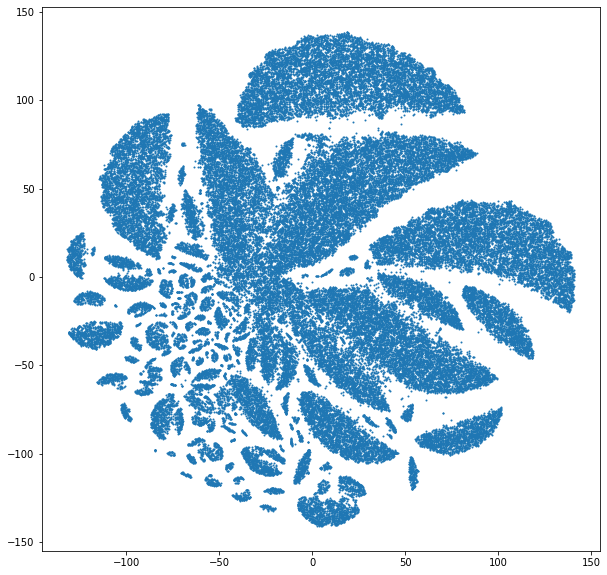

3037

In [23]:
plotData(14301135, test)
del test, tmp; gc.collect()

In [24]:
# ----- PREDICT -----

In [25]:
from cuml.neighbors import NearestNeighbors

In [26]:
%%time

knn = NearestNeighbors(n_neighbors=21, metric='euclidean')
knn.fit(embeddings)
_, aid_nns = knn.kneighbors(embeddings)
aid_nns = aid_nns[:, 1:]
aid_nns

CPU times: user 40.1 s, sys: 33 s, total: 1min 13s
Wall time: 1min 13s


array([[1162879, 1506003, 1717285, ...,  994020,  584602, 1328102],
       [1525262, 1838534,   50974, ..., 1449841, 1401550,  839008],
       [ 869710,  909937, 1198720, ..., 1352976, 1686838, 1113341],
       ...,
       [ 838226, 1735048,  955268, ...,  391592, 1618807, 1776834],
       [  67929, 1691644,   98015, ..., 1093417, 1633075,  527738],
       [1837736,  876482, 1183219, ...,  342538, 1609497,  131072]])

In [27]:
from collections import defaultdict

test = cudf.read_parquet(f'../input/{path}/test.parquet')

session_types = ['clicks', 'carts', 'orders']
gr = test.reset_index(drop=True).to_pandas().groupby('session')
test_session_AIDs = gr['aid'].apply(list)
test_session_types = gr['type'].apply(list)

labels = []

type_weight_multipliers = {0: 1, 1: 6, 2: 3}
for AIDs, types in zip(test_session_AIDs, test_session_types):
    #if len(AIDs) >= 20:
        # if we have enough aids (over equals 20) we don't need to look for candidates! we just use the old logic
     #   weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
     #   aids_temp=defaultdict(lambda: 0)
     #   for aid,w,t in zip(AIDs,weights,types): 
     #       aids_temp[aid]+= w * type_weight_multipliers[t]
            
     #   sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
     #   labels.append(sorted_aids[:20])
    #else:
    AIDs = list(dict.fromkeys(AIDs[::-1]))
        
    most_recent_aid = AIDs[0]
        
    nns = list(aid_nns[most_recent_aid])
                        
    labels.append((AIDs+nns)[:20])

In [28]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

submission = pd.concat(prediction_dfs).reset_index(drop=True)

if SAVE: submission.to_csv('submission.csv', index=False)
if SHOW: display(submission)

,session_type,labels
0,12899779_clicks,59625 1175382 1430494 753060 1291379 10091 587...
1,12899780_clicks,1142000 736515 973453 582732 512037 1361542 51...
2,12899781_clicks,918667 199008 194067 57315 141736 567666 69614...
3,12899782_clicks,1007613 595994 1033148 834354 479970 1696036 8...
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 ...
...,...,...
5015404,14571577_orders,1141710 665035 317105 295685 1177489 1244879 4...
5015405,14571578_orders,519105 1359756 253131 651844 452589 1816884 75...
5015406,14571579_orders,739876 1553685 914861 3904 356793 1749006 1419...
5015407,14571580_orders,202353 471579 1218163 683324 1478157 1418668 6...


In [29]:
def localMetrics(sub, df_true=None):
    # -- load ground truth
    if df_true is None:
        df_true = pd.read_parquet('../input/otto-train-and-test-data-for-local-validation/test_labels.parquet')
        df_true = df_true.rename(columns = {'ground_truth': 'aids'} )
    if GPU: df_true = df_true.to_pandas()
        
    # -- calculate metrics
    lsub = sub.copy()
    if GPU: lsub = lsub.to_pandas()
    lsub['session'] = lsub.session_type.apply(lambda x: np.int64(x.split('_')[0]))
    lsub['type']    = lsub.session_type.apply(lambda x: x.split('_')[1]) 
    lsub['labels']  = lsub.labels.apply(lambda x: [np.int64(i) for i in x.split()[:20]])

    test_labels = df_true.copy()
    test_labels = test_labels.merge(lsub, how='left', on=['session', 'type'])
    test_labels['labels'] = test_labels['labels'].fillna('')
    
    test_labels['hits']     = test_labels.apply(lambda df: len(set(df.aids).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.aids.str.len().clip(0,20)  
    
    recall_per_type = test_labels.groupby(['type'])['hits'].sum() / test_labels.groupby(['type'])['gt_count'].sum() 
    
    series = pd.Series({'clicks':0.1, 'carts':0.3, 'orders':0.6})
    if GPU: series = series.to_pandas()
    
    recall_per_type = (recall_per_type * series).fillna(0)
    score = recall_per_type.sum()
    
    r = {'clicks':0, 'carts':0, 'orders':0}
    for key in r.keys():
        if test_labels[test_labels['type'] == key].shape[0] > 0:
            r[key] = recall_per_type[key]
    print(f"{score:.3f} = {r['clicks']:.3f} + {r['carts']:.3f} + {r['orders']:.3f}")
    print('score:', score)
    return score

In [30]:
del _, aid_nns, knn, test, gr, test_session_AIDs, test_session_types, predictions
gc.collect()

21

In [31]:
%%time
# ~ 3m 10s
if LOCAL:
    localMetrics(submission)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [32]:
#submission = pd.read_csv('submission.csv')
#submission

In [33]:
#last20 = pd.read_parquet('../input/otto-last-items/local_lastItems.parquet')
#last20.rename(columns={'labels':'aids'}, inplace=True)
#last20['type'] = last20['type'].map({0:'clicks', 1:'carts', 2:'orders'})
#last20

In [34]:
%%time
# ~ 3m 10s
# Совпадение предсказания модели с последними 20 элементами истории
#localMetrics(submission, last20) # 0.997 = 0.100 + 0.299 + 0.598
                                 # 0.9970266654687556

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
